# Guia Prático de Pré-processamento de Texto (PT-BR) — Versão Simplificada

Este notebook é um guia didático para aprender **NLP aplicado à classificação de texto**.  
Etapas incluídas:

1. Exploração inicial dos dados (EDA)
2. Limpeza e normalização de texto
3. Tokenização, stopwords, stemming e lematização
4. Frequência de palavras
5. Representação com TF–IDF
6. Treino/teste com Naive Bayes (baseline)

---

### Conceitos-chave

- **Tokenização** → dividir o texto em palavras.  
- **Stopwords** → palavras muito comuns que não ajudam na classificação (ex.: "de", "a", "o").  
- **Stemming** → reduz a palavra para uma raiz (ex.: "agredindo" → "agred").  
- **Lematização** → reduz para a forma dicionário (ex.: "agredindo" → "agredir").  
- **n-grams** → combinações de n palavras consecutivas (1=unigram, 2=bigram).  
- **TF–IDF** → transforma texto em vetores.  
  - TF = frequência de um termo no documento  
  - IDF = quão raro é no corpus  
  - resultado: destaca termos que são **característicos** de cada classe.


## 1) Imports e Configuração

In [5]:
import re, string
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import nltk
nltk.download('stopwords') #PRECISEI BAIXAR
nltk.download('rslp')

import spacy
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from unidecode import unidecode

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# carregar modelo spaCy em português
nlp = spacy.load("pt_core_news_sm")

# stopwords e stemmer do NLTK
PT_STOPWORDS = set(stopwords.words("portuguese"))
STEMMER = RSLPStemmer()

plt.rcParams["figure.figsize"] = (7,4)
print("Ambiente pronto!")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/siqueira/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /home/siqueira/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


Ambiente pronto!


In [7]:
import imports 

## 2) Carregar Dados de Exemplo

In [4]:
# Mini dataset fictício (substitua pelo seu CSV real)
data = {
    "text": [
        "A vítima relatou ameaça grave por parte do companheiro via telefone.",
        "Durante a discussão, ocorreu lesão corporal com empurrões e tapas.",
        "O autor enviou mensagens intimidatórias, dizendo que iria machucar a vítima.",
        "Foi registrado boletim por agressão física, resultando em hematomas no braço.",
        "Sem indícios claros de crime, apenas desentendimento verbal entre as partes."
    ],
    "label": ["AMEAÇA", "LESÃO CORPORAL", "AMEAÇA", "LESÃO CORPORAL", "OUTRO"]
}
df = pd.DataFrame(data)
df.head()

,text,label
0,A vítima relatou ameaça grave por parte do com...,AMEAÇA
1,"Durante a discussão, ocorreu lesão corporal co...",LESÃO CORPORAL
2,"O autor enviou mensagens intimidatórias, dizen...",AMEAÇA
3,"Foi registrado boletim por agressão física, re...",LESÃO CORPORAL
4,"Sem indícios claros de crime, apenas desentend...",OUTRO


## 3) EDA (Exploratory Data Analysis)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     5 non-null      object
 1   label    5 non-null      object
 2   n_chars  5 non-null      int64 
 3   n_words  5 non-null      int64 
dtypes: int64(2), object(2)
memory usage: 292.0+ bytes


None


Distribuição de classes:


label
AMEAÇA            2
LESÃO CORPORAL    2
OUTRO             1
Name: count, dtype: int64

,n_chars,n_words
count,5.000000,5.000000
mean,72.600000,10.800000
std,5.176872,0.447214
min,66.000000,10.000000
25%,68.000000,11.000000
50%,76.000000,11.000000
75%,76.000000,11.000000
max,77.000000,11.000000


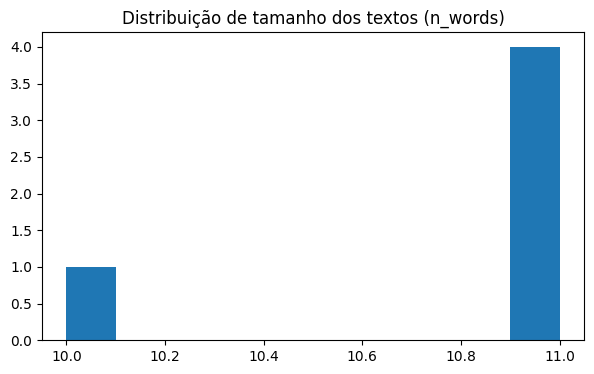

In [14]:
print("Info:")
display(df.info())
print("\nDistribuição de classes:")
display(df['label'].value_counts())

# tamanho dos textos
df['n_chars'] = df['text'].apply(len)
df['n_words'] = df['text'].apply(lambda x: len(x.split()))
display(df[['n_chars','n_words']].describe())

plt.hist(df['n_words'], bins=10)
plt.title("Distribuição de tamanho dos textos (n_words)")
plt.show()

## 4) Limpeza de Texto

In [22]:
def clean_text(text):
    t = text.lower()
    t = re.sub(r"(https?://\S+|www\.\S+)", " ", t)  # urls
    t = re.sub(r"\b[\w.-]+@[\w.-]+\.\w{2,}\b", " ", t)  # emails
    t = re.sub(r"@\w+", " ", t)  # menções
    t = re.sub(r"\d+", " ", t)  # números
    t = t.translate(str.maketrans("", "", string.punctuation))  # pontuação
    t = unidecode(t)  # acentos
    t = re.sub(r"\s+", " ", t).strip()
    return t

df['clean'] = df['text'].apply(clean_text)
df[['text','clean']]

,text,clean
0,A vítima relatou ameaça grave por parte do com...,a vitima relatou ameaca grave por parte do com...
1,"Durante a discussão, ocorreu lesão corporal co...",durante a discussao ocorreu lesao corporal com...
2,"O autor enviou mensagens intimidatórias, dizen...",o autor enviou mensagens intimidatorias dizend...
3,"Foi registrado boletim por agressão física, re...",foi registrado boletim por agressao fisica res...
4,"Sem indícios claros de crime, apenas desentend...",sem indicios claros de crime apenas desentendi...


## 5) Tokenização, Stopwords, Stemming e Lematização

In [23]:
def tokenize(text): return text.split()
def remove_stop(tokens): return [t for t in tokens if t not in PT_STOPWORDS]
def stem_tokens(tokens): return [STEMMER.stem(t) for t in tokens]
def lemmatize(text): return [tok.lemma_ for tok in nlp(text)]

df['tokens'] = df['clean'].apply(tokenize)
df['nostop'] = df['tokens'].apply(remove_stop)
df['stem'] = df['nostop'].apply(stem_tokens)
df['lemmas'] = df['clean'].apply(lemmatize)

df[['clean','nostop','stem','lemmas']].head()

,clean,nostop,stem,lemmas
0,a vitima relatou ameaca grave por parte do com...,"[vitima, relatou, ameaca, grave, parte, compan...","[vit, relat, ameac, grav, part, companh, via, ...","[o, vitimo, relatar, ameaca, grave, por, parte..."
1,durante a discussao ocorreu lesao corporal com...,"[durante, discussao, ocorreu, lesao, corporal,...","[dur, discussa, ocorr, lesa, corpor, empurro, ...","[durante, o, discussao, ocorrer, lesao, corpor..."
2,o autor enviou mensagens intimidatorias dizend...,"[autor, enviou, mensagens, intimidatorias, diz...","[autor, envi, mens, intimid, diz, iri, machuc,...","[o, autor, enviar, mensagem, intimidatoria, di..."
3,foi registrado boletim por agressao fisica res...,"[registrado, boletim, agressao, fisica, result...","[registr, boletim, agressa, fisic, result, hem...","[ser, registrar, boletim, por, agressao, fisic..."
4,sem indicios claros de crime apenas desentendi...,"[indicios, claros, crime, apenas, desentendime...","[indici, clar, crim, apen, desentend, verb, part]","[sem, indicio, claro, de, crime, apenas, desen..."


## 6) Frequência de Palavras

In [24]:
from itertools import chain

def top_freq(token_lists, k=10):
    counts = Counter(chain.from_iterable(token_lists))
    return pd.DataFrame(counts.most_common(k), columns=['token','freq'])

top_freq(df['nostop'], k=15)

,token,freq
0,vitima,2
1,relatou,1
2,ameaca,1
3,grave,1
4,parte,1
5,companheiro,1
6,via,1
7,telefone,1
8,durante,1
9,discussao,1


## 7) Representação com TF–IDF

In [25]:
X_text = df['clean'].tolist()
y = df['label'].tolist()

tfidf = TfidfVectorizer(stop_words=list(PT_STOPWORDS), ngram_range=(1,2))
X_tfidf = tfidf.fit_transform(X_text)
print("Shape da matriz TF-IDF:", X_tfidf.shape)

# termos com maior IDF (mais raros)
idf_sorted = sorted(zip(tfidf.idf_, tfidf.get_feature_names_out()), reverse=True)[:10]
pd.DataFrame(idf_sorted, columns=['idf','termo'])

Shape da matriz TF-IDF: (5, 68)


,idf,termo
0,2.098612,vitima relatou
1,2.098612,via telefone
2,2.098612,via
3,2.098612,verbal partes
4,2.098612,verbal
5,2.098612,telefone
6,2.098612,tapas
7,2.098612,resultando hematomas
8,2.098612,resultando
9,2.098612,relatou ameaca


## 8) Baseline com Naive Bayes

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_text, y, test_size=0.2, random_state=42, stratify=y)

pipe = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words=list(PT_STOPWORDS), ngram_range=(1,2))),
    ("clf", MultinomialNB())
])

pipe.fit(X_train, y_train)
preds = pipe.predict(X_test)

print(classification_report(y_test, preds))
cm = confusion_matrix(y_test, preds, labels=sorted(set(y)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(set(y)))
disp.plot(values_format='d')
plt.show()

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

## 9) Próximos Passos

- Testar Logistic Regression e SVM
- Balancear classes
- Usar embeddings (BERT, LegalBERT-pt)
- Documentar sempre as escolhas!